# AutoEncoders

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Reshape, UpSampling2D, Activation
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.callbacks import EarlyStopping
from PIL import Image
from keras.utils import to_categorical
from keras import backend as K
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import cv2
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import seaborn as sns
import urllib
from pathlib import Path
from tqdm.notebook import tqdm
import pickle
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Extract Image Features from last Dense layer of CNN
We can then use these to determine the most similar images to a given image. We'll use the Intel images data set.

In [3]:
# To read the pickles we can do this:
with open(os.path.join("/content", "drive", "MyDrive", "data", "intel", "x_train.p"), "rb") as f:
    x_train = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "intel", "x_test.p"), "rb") as f:
    x_test = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "intel", "y_train.p"), "rb") as f:
    y_train = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "intel", "y_test.p"), "rb") as f:
    y_test = pickle.load(f)

In [4]:
classes_dict = {0: 'Buildings', 1: 'Forest', 2: 'Glacier',
                3: 'Mountains', 4: 'Sea', 5: 'Street'}

In [5]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(14034, 128, 128, 3)
(3000, 128, 128, 3)
(14034, 6)
(3000, 6)


In [6]:
x_train = x_train.astype('float32')
x_train /= 255
x_test = x_test.astype('float32')
x_test /= 255

In [7]:
# We create out network
model = Sequential(name='cnn')
# 1st convolutional layer
model.add(Conv2D(64, kernel_size=4, activation='relu', input_shape=(128,128,3), name='1st_CL'))
model.add(MaxPooling2D(pool_size =(4 ,4), name='1st_MP'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
#2nd convolutional layer
model.add(Conv2D(64, kernel_size=4, activation='relu', name='2nd_CL'))
model.add(MaxPooling2D(pool_size =(4 ,4), name='2nd_MP'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
#Fully-connected layer (flatten first)
model.add(Flatten())        
model.add(Dense(128, activation='relu', name='Dense'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
# Output Softmax Layer
model.add(Dense(6, activation = 'softmax', name='Output_Softmax'))

In [8]:
fc2_model = Model(inputs=model.input, outputs=model.get_layer("Dense").output)
print(fc2_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1st_CL_input (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
1st_CL (Conv2D)              (None, 125, 125, 64)      3136      
_________________________________________________________________
1st_MP (MaxPooling2D)        (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
2nd_CL (Conv2D)              (None, 28, 28, 64)        65600     
_________________________________________________________________
2nd_MP (MaxPooling2D)        (None, 7, 7, 64)          0     

In [9]:
feature_size = int(fc2_model.output.shape[1])
n_examples = len(x_test)
data_fc2 =[]
for i, x in enumerate(x_test):
  x_ = np.expand_dims(x, axis=0) 
  fc2 = fc2_model.predict(x_)
  data_fc2.append(fc2)

In [10]:
fc2_data = np.asarray(data_fc2)

In [11]:
fc2_shaped = fc2_data[:, 0, :]

In [12]:
fc2_shaped.shape

(3000, 128)

We can now use K-Nearest-Neighbors to determine the closest neighbors to a given image.

In [13]:
neigh = NearestNeighbors(n_neighbors=4, p=2)
neigh.fit(fc2_shaped)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                 radius=1.0)

In [14]:
def show_image(im):
  fig, ax = plt.subplots(figsize=(4,4))
  plt.imshow(im)
  plt.axis('off')
  plt.show()

In [15]:
def most_similar(id):
  indices=[id]
  X = fc2_shaped[indices]
  nn = neigh.kneighbors(X)
  nn  # nn = (distances, indices)
  print("Image number:", id, "\nClass:", classes_dict[pd.Series(y_test[id]).idxmax(axis=1)])
  show_image(x_test[id])
  print("\n 3 Most Similar Images: \n")
  for s in range(1,4):  
    print("#",s,"\nImage number: ", nn[1][0][s], "\nDistance=", round(nn[0][0][s],2))
    show_image(x_test[nn[1][0][s]])
    print("Class: ", classes_dict[pd.Series(y_test[nn[1][0][s]]).idxmax(axis=1)])
    print("\n")

Image number: 300 
Class: Mountains


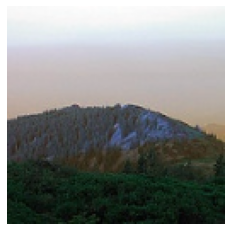


 3 Most Similar Images: 

# 1 
Image number:  2593 
Distance= 0.18


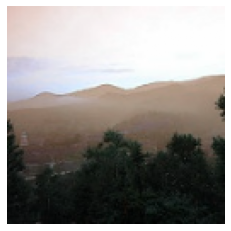

Class:  Mountains


# 2 
Image number:  1726 
Distance= 0.19


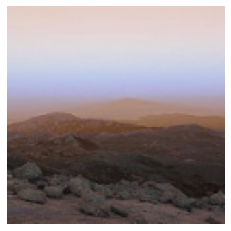

Class:  Mountains


# 3 
Image number:  653 
Distance= 0.19


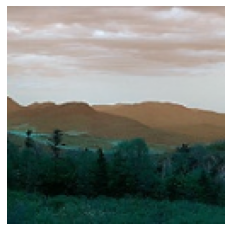

Class:  Mountains




In [16]:
most_similar(300)

# AutoEncoder

Adding noise

We obtain a noisy version of our data by adding Gaussian (normal) noise to each pixel, and clipping pixel values between 0 and 1.

In [17]:
# Let's reduce the data set to avoid memory issues...
x_train_short = x_train[:3000,:,:,:]
x_test_short = x_train[:1000,:,:,:]
y_train_short = x_train[:3000,:]
y_test_short = x_train[:1000,:]

In [18]:
noise_factor = 0.15
x_train_noisy = x_train_short + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_short.shape) 
x_test_noisy = x_test_short + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_short.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Let's visualise some examples from the original test set as well as their noisy version.

Text(0.5, 1.0, 'Noisy Version')

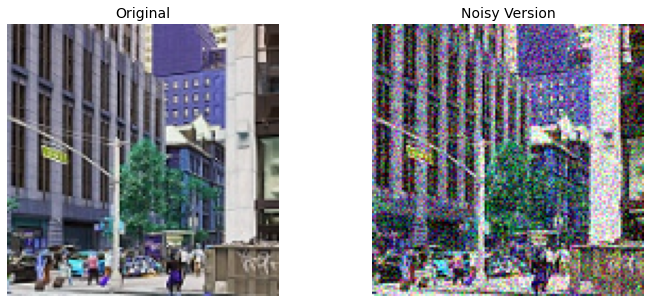

In [19]:
i=np.random.randint(200)
fig, ax = plt.subplots(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(x_test_short[i])
plt.axis('off')
plt.title('Original', fontsize=14)
plt.subplot(1,2,2)
plt.imshow(x_test_noisy[i])
plt.axis('off')
plt.title('Noisy Version', fontsize=14)


For the encoder we will use convolutional layers and Max-Pooling (to down-sample the image), followed by a Dense layer. This gives a hidden "code" of 128 dimensions. For the decoder we use a Dense layer to upscale to the same dimension before convolutional layers and UpSampling. We also include Batch Normalization, which significantly speeds up training.

More precisely, for the encoder we will use the following architecture:
* Convolutional layer
* MaxPooling
* Batch Normalization
* Convolutional layer
* MaxPooling
* Batch Normalization
* Dense layer

From this we obtain a 128-dimensional encoded representation, this is the "code" of the autoencoder.

The decoder will have the following architecture:
* Dense layer (to reshape/upsample to a suitable representation for the next convolutional layer)
* Convolutional layer
* UpSampling
* Batch Normalization
* Convolutional layer
* UpSampling
* Batch Normalization
* Convolutional layer (this layer should generate ouput images, of the same format as the input of the encoder)

All convolutional layers (except for the output layer) will have 32 filters (feature maps), a kernel size of 3x3, strides of 1x1, "ReLU" activations and "same" padding. All MaxPooling and UpSampling operations will have size 2x2. To connect a convolutional layer after a Dense layer, use a Reshape layer to transform the data to the right shape for convolutions.

The final convolutional layer should produce images in the same format as the input. It will have a kernel size of 3x3, and use "same" padding. Think of a suitable activation, and the right number of filters.

In [20]:
x_train.shape

(14034, 128, 128, 3)

In [21]:
# We create our auto-encoder network
autoencoder = Sequential()

# ENCODER
# 1st convolutional layer
autoencoder.add(Conv2D(64, kernel_size=(3,3), padding='same', strides=(1,1), input_shape=(128,128,3)))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1)))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(MaxPooling2D(pool_size = (2 ,2)))
autoencoder.add(Dropout(0.1))
#DECODER
autoencoder.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(Conv2D(64, kernel_size=(3,3),  strides=(1,1), padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(UpSampling2D(size = (2 ,2)))
autoencoder.add(Conv2D(3, kernel_size=(3,3), activation='sigmoid', strides=(1,1), padding='same'))

print(autoencoder.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0

In [22]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error') 

We use the noisy data as input and the original data as target, such that the model learns to denoise the data.

In [23]:
batch_size = 80
epochs = 30

autoencoder.fit(x_train_noisy, x_train_short,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=1/12)

Epoch 1/30
35/35 [==============================] - 17s 382ms/step - loss: 0.0270 - val_loss: 0.0640
Epoch 2/30
35/35 [==============================] - 12s 338ms/step - loss: 0.0060 - val_loss: 0.0612
Epoch 3/30
35/35 [==============================] - 12s 340ms/step - loss: 0.0052 - val_loss: 0.0564
Epoch 4/30
35/35 [==============================] - 12s 340ms/step - loss: 0.0047 - val_loss: 0.0521
Epoch 5/30
35/35 [==============================] - 12s 341ms/step - loss: 0.0045 - val_loss: 0.0469
Epoch 6/30
35/35 [==============================] - 12s 343ms/step - loss: 0.0044 - val_loss: 0.0418
Epoch 7/30
35/35 [==============================] - 12s 343ms/step - loss: 0.0041 - val_loss: 0.0358
Epoch 8/30
35/35 [==============================] - 12s 347ms/step - loss: 0.0041 - val_loss: 0.0309
Epoch 9/30
35/35 [==============================] - 12s 345ms/step - loss: 0.0040 - val_loss: 0.0277
Epoch 10/30
35/35 [==============================] - 12s 348ms/step - loss: 0.0040 - val_lo

In [24]:
def plot_loss(history):
  n_epochs = max(history.epoch)+1
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = range(1,n_epochs+1)
  fig, ax = plt.subplots(figsize=(18,6))
  ax = sns.lineplot(x=epochs, y=loss_train,  label='training loss')
  ax = sns.lineplot(x=epochs, y=loss_val,  label='validation loss')
  ax.grid(color='black', linestyle='-', linewidth=0.1)
  ax.set_xticks(np.arange(1,n_epochs,2))
  ax.set_xlim(1)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

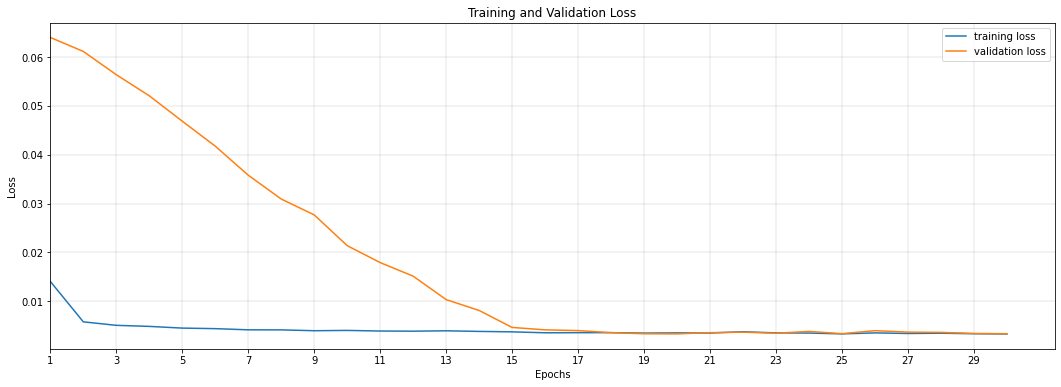

In [25]:
plot_loss(autoencoder.history)

Looks like we reached some minimum at epoch 15 and after that training became irrelevant.

Model Evaluation


We cannot use an accuracy measure here like in supervised learning, since there are no target labels. We can compute a loss value for the test set, but this doesn't provide an intuitive result. Therefore we will also inspect a few reconstructions visually. First we use the autoencoder to denoise the test set, then we visualise a few examples (the original images, the noisy versions, and their denoised reconstructions).

In [26]:
test_loss = autoencoder.evaluate(x_test_noisy, x_test_short, batch_size=batch_size)
print("Test loss:", test_loss)

x_test_reconstr = autoencoder.predict(x_test_noisy, batch_size=batch_size)
x_train_reconstr = autoencoder.predict(x_train_noisy, batch_size=batch_size)

13/13 [==============================] - 2s 152ms/step - loss: 0.0032
Test loss: 0.0031567236874252558


Text(0.5, 0.98, 'On Test data')

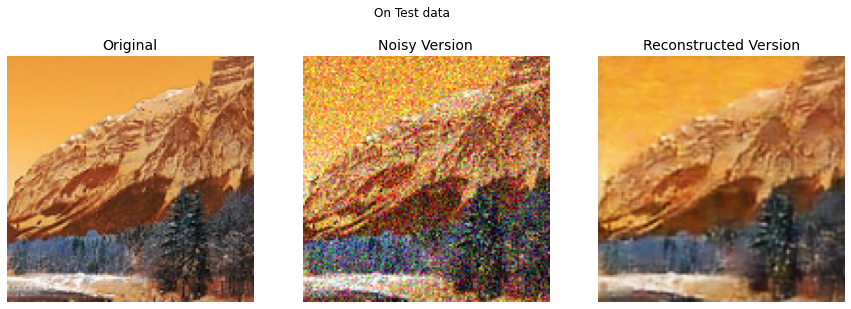

In [27]:
i=np.random.randint(200)
fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(x_test_short[i])
plt.axis('off')
plt.title('Original', fontsize=14)
plt.subplot(1,3,2)
plt.imshow(x_test_noisy[i])
plt.axis('off')
plt.title('Noisy Version', fontsize=14)
plt.subplot(1,3,3)
plt.imshow(x_test_reconstr[i])
plt.axis('off')
plt.title('Reconstructed Version', fontsize=14)
plt.suptitle('On Test data')

Text(0.5, 0.98, 'On Train data')

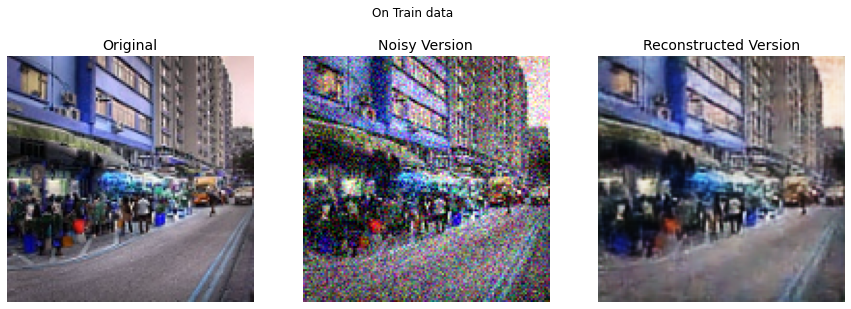

In [28]:
i=np.random.randint(200)
fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(x_train_short[i])
plt.axis('off')
plt.title('Original', fontsize=14)
plt.subplot(1,3,2)
plt.imshow(x_train_noisy[i])
plt.axis('off')
plt.title('Noisy Version', fontsize=14)
plt.subplot(1,3,3)
plt.imshow(x_train_reconstr[i])
plt.axis('off')
plt.title('Reconstructed Version', fontsize=14)
plt.suptitle('On Train data')

We save the model to a .h5 file, such that we can load it later in other notebooks.

In [29]:
autoencoder.save(os.path.join("/content", "drive", "MyDrive", "data", "intel", "autoencoder.h5"))

Take a random image that already has some kind of noise and try to denoise it with the previous model.

In [30]:
old_photo = cv2.imread(os.path.join("/content", "drive", "MyDrive", "data", "intel","old_photo1.jpg"))
image = cv2.resize(old_photo, (128,128))

In [31]:
image = image.astype('float32')
image /= 255

In [32]:
image_ = np.expand_dims(image, axis=0) 

In [33]:
img_reconstr = autoencoder.predict(image_)

In [34]:
img_reconstr.shape

(1, 128, 128, 3)

Text(0.5, 1.0, 'Reconstruction')

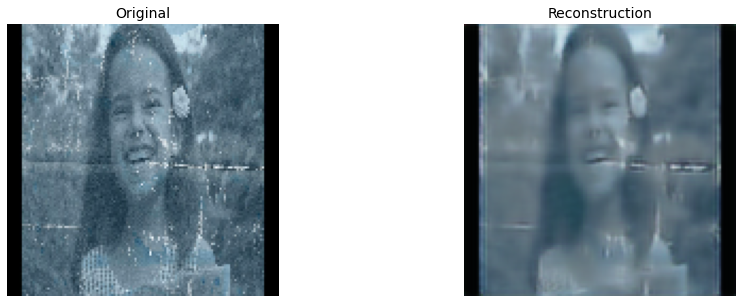

In [35]:
i=np.random.randint(200)
fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.title('Original', fontsize=14)
plt.subplot(1,2,2)
img_reconstr_ = img_reconstr[0,:,:,:]
plt.imshow(img_reconstr_)
plt.axis('off')
plt.title('Reconstruction', fontsize=14)